# Moving average trading

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import security_comparison as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interactive, ToggleButtons, FloatSlider, IntSlider, SelectionSlider
from IPython.display import display

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Default parameters

In [2]:
DIRNAME = 'data'
PLOT_DIR = 'plots'
initial_wealth = 100.0
pd.options.display.float_format = '{:,.2f}'.format
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
gridcolor = '#ededed'

TICKER = 'FP.PA'
end_date = '2021-03-19'

### Data download

In [3]:
raw = sc.load_security(dirname=DIRNAME, ticker=TICKER, period='10y')

Loading data from data/FP.PA_10y.pkl


In [4]:
security = pd.DataFrame(raw[f'Close_{TICKER}'])
security.rename(columns={f'Close_{TICKER}': "Close"},
                inplace=True)

#security

## Trading strategy

### Supporting routines

In [5]:
def get_fee(data, fee_pct):
    '''
    Return fees associated to position switches
    fee_pct -> brokers fee 
    fee -> $ fee corresponding to fee_pct
    '''
    # Add a fee for each movement
    fee = (fee_pct * data[data.SWITCH == positions[0]].CUMRET_EMA.sum())
    fee += (fee_pct * data[data.SWITCH == positions[1]].CUMRET_EMA.sum())
    return fee

In [6]:
def get_cumret(data, strategy, fee=0):
    '''
    Returns cumulative return for the given strategy
    If strategy is EMA, returns cumulative returns net of fees
    '''
    if strategy.lower() == 'hold':
        return data.CUMRET_HOLD[-1]/initial_wealth - 1
    elif strategy.lower() == 'ema':
        return (data.CUMRET_EMA[-1]-fee)/initial_wealth - 1
    else:
        raise ValueError(
            f"strategy {strategy} should be either of ema or hold")

In [7]:
def display_full_dataframe(data):
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 1000,
                           'display.precision', 2,
                           'display.colheader_justify',
                           'left'):
        display(data)

### Main algorithms

In [8]:
positions = ['long', 'short', 'n/c']
switches = ['buy', 'sell', 'n/c']

def build_positions(df):
    '''
    This agorithm builds desired positions for the EMA strategy 
    *** Long strategy only ***
    POSITION -> cash, long (short pending)
    SWICH -> buy, sell, n/c (no change)
    '''
    n_time_steps = df.shape[0]
    positions, switches = ([] for i in range(2))

    positions.append('cash')
    switches.append('n/c')

    for step in range(1, n_time_steps):  # Long strategy only
        price = df.loc[df.index[step], 'Close']
        mean = df.loc[df.index[step], 'EMA']
        if positions[step - 1] == 'cash':  # previous position: cash
            if df.loc[df.index[step], 'SIGN'] in [0, -1]:
                positions.append('cash')
                switches.append('n/c')
            elif df.loc[df.index[step], 'SIGN'] == 1:
                positions.append('long')
                switches.append('buy')
            else:
                raise ValueError(f'Inconsistent sign')
        elif positions[step - 1] == 'long':  # previous position: long
            if df.loc[df.index[step], 'SIGN'] in [0, 1]:
                positions.append('long')
                switches.append('n/c')
            elif df.loc[df.index[step], 'SIGN'] == -1:
                positions.append('cash')
                switches.append('sell')
            else:
                raise ValueError(f'Inconsistent sign')
        else:
            raise ValueError(
                f"step {step}: previous position {positions[step - 1]} sign:{df.loc[df.index[step], 'SIGN']}")
    df.insert(loc=len(df.columns), column='POSITION', value=positions)
    df.insert(loc=len(df.columns), column='SWITCH', value=switches)
    return df

def get_strategy(df, span, buffer, debug=False, reactivity=1):
    '''
    ***At this point, only a long strategy is considered***
    Implements running-mean (ewm) strategy
    Input dataframe df has date index & security value 'Close'

    Variables:
    span       -> number of rolling days
    reactivity -> reactivity to market change in days (should be set to 1)
    buffer     -> % above ema to trigger buy

    Returns:
    A dataframe with original data + following columns
    EMA -> exponential moving average
    SIGN -> 1 : above buffer 0: in buffer -1: below buffer
    SWITCH -> buy / sell / n/c (no change)
    RET -> 1 + % daily return
    CUMRET_HOLD -> cumulative returns for a hold strategy
    RET2 -> 1 + % daily return when Close > EMA (***long strategy only***)
    CUMRET_EMA -> cumulative returns for the EMA strategy
    '''
    # Compute exponential weighted mean
    df['EMA'] = df.Close.ewm(span=span, adjust=False).mean()
    if debug:  # include buffer limits in dataframe for printing
        df.insert(loc=1, column='EMA-', value=df['EMA']*(1-buffer))
        df.insert(loc=len(df.columns), column='EMA+',
                  value=df['EMA']*(1+buffer))
    df['SIGN'] = np.where(df.Close - df.EMA*(1 + buffer) > 0, 1,
                          np.where(df.Close - df.EMA*(1 - buffer) < 0, -1, 0)
                          )
    df['SIGN'] = df['SIGN'].shift(reactivity)
    df.loc[df.index[0], 'SIGN'] = 0.0  # set first value to 0

    df = build_positions(df)  # compute position and switch columns

    # Compute returns, cumulative returns and 'wealth' for hold strategy
    df['RET'] = 1.0 + df.Close.pct_change()
    df.loc[df.index[0], 'RET'] = 1.0  # set first value to 1.0
    df['CUMRET_HOLD'] = initial_wealth * df.RET.cumprod(axis=None, skipna=True)

    # Cumulative wealth for ema strategy
    df['RET_EMA'] = np.where(df.POSITION == 'long', df.RET, 1.0)
    df['CUMRET_EMA'] = df.RET_EMA.cumprod(
        axis=None, skipna=True) * initial_wealth
    df.loc[df.index[0], 'CUMRET_EMA'] = initial_wealth
    df = df.drop(['RET_EMA'], axis=1)
    df = df.drop(['SIGN'], axis=1)
    #df.to_csv('check.csv', sep=',')
    return df


#### Test driver for main algorithm

In [9]:
start_date = '2018-12-31'
end_date = '2021-03-19'
span   = 29
buffer = .015
reactivity = 1
df = get_strategy(security.loc[start_date:end_date, :].copy(),
                  span,
                  buffer)
df

,Close,EMA,POSITION,SWITCH,RET,CUMRET_HOLD,CUMRET_EMA
Date,,,,,,,
2018-12-31,40.32,40.32,cash,n/c,1.00,100.00,100.00
2019-01-02,40.74,40.35,cash,n/c,1.01,101.03,100.00
2019-01-03,40.39,40.35,cash,n/c,0.99,100.16,100.00
2019-01-04,41.40,40.42,cash,n/c,1.02,102.66,100.00
2019-01-07,41.30,40.48,long,buy,1.00,102.43,99.77
...,...,...,...,...,...,...,...
2021-03-15,41.29,38.84,long,n/c,0.98,102.40,98.23
2021-03-16,40.76,38.97,long,n/c,0.99,101.09,96.98
2021-03-17,40.61,39.08,long,n/c,1.00,100.71,96.61


## Plotting functions

### Supporting routines

In [10]:
def save_figure(p_file, dpi=360, extension='png'):
    '''
    Save figure to file
    '''
    filename = os.path.join(PLOT_DIR, p_file + f'.{extension}')
    plt.savefig(filename,
                dpi=dpi,
                transparent=False,
                orientation='landscape',
                bbox_inches='tight')

In [11]:
def plot_arrows(axis, data):
    ''' 
    Draws position-switching arrows on ax2
    '''
    vertical_range = data['Close'].max() - data['Close'].min()
    horizont_range = (data.index[-1] - data.index[0]).days
    arrow_length = vertical_range/10
    head_width = horizont_range/100
    head_length = vertical_range/50
    space = vertical_range/100  # space bw arrow tip and curve

    for row in range(data.shape[0]):
        if data.SWITCH[row] == switches[0]:  # buy
            y_start = data.loc[data.index[row], 'Close'] + arrow_length
            color = colors[2]
            dy = -arrow_length+space
        elif data.SWITCH[row] == switches[1]:  # sell
            y_start = data.loc[data.index[row], 'Close'] - arrow_length
            color = colors[3]
            dy = arrow_length-space
        else:  # don't draw the arrow
            continue
        arrow_start = data.loc[data.index[row], 'Close']
        axis.arrow(x=data.index[row], y=y_start,
                   dx=0, dy=dy,
                   head_width=head_width,
                   head_length=head_length,
                   length_includes_head=True,
                   linestyle='-',
                   color=color
                   )

### Main plotting function

In [12]:
year_month_fmt = mdates.DateFormatter('%b-%y')
title_size = 14

def plot_moving(span, fee_pct, buffer, reactivity=1):
    '''
    Plots price with moving average
    span -> rolling span
    fee -> fee associated with switching position
    reactivity -> time lag in days after Close (normally = 1)
    '''
    format    = '%d-%b-%Y'
    
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    # Extract time window
    df = get_strategy(security.loc[start_date:end_date, :].copy(),
                      span,
                      buffer,
                      debug=False)
    fee = get_fee(df, fee_pct)
    hold = get_cumret(df, 'hold')  # cumulative returns for hold strategy
    ema = get_cumret(df, 'ema', fee)  # cumulative returns for EMA strategy

    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax1.plot(df.index, df.Close, linewidth=1, label='Price')
    ax1.plot(df.index, df.EMA, linewidth=1, label=f'{span}-days EMA')

    ax1.legend(loc='best')
    ax1.set_ylabel('Price ($)')
    ax1.xaxis.set_major_formatter(year_month_fmt)
    ax1.grid(b=None, which='both', axis='both',
             color=gridcolor, linestyle='-', linewidth=1)

    title = f'{TICKER} Hold: {hold:.1%} / {span}-day mean ({buffer:.2%} buffer): {ema:.1%} ({start.strftime(format)} to {end.strftime(format)})'
    ax1.set_title(title, fontsize=title_size)

    plot_arrows(ax1, df)
    return df


#### Test driver for main plot

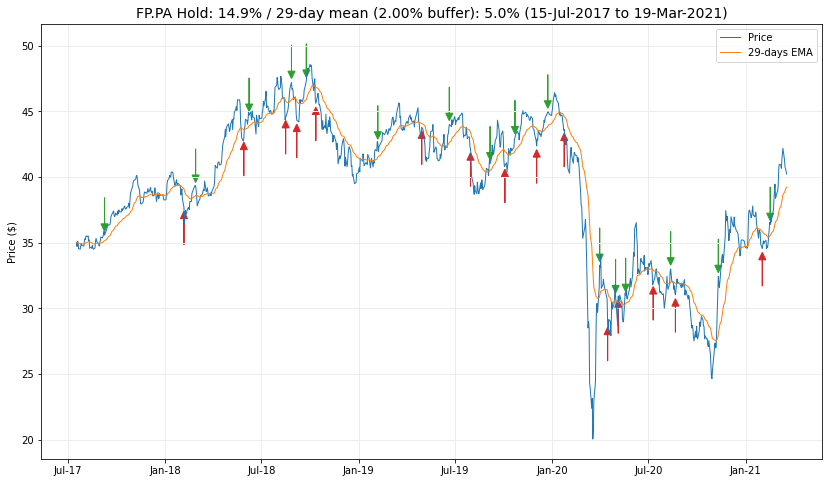

In [13]:
start_date = '2017-07-15'
df = plot_moving(span=29, fee_pct=.004, buffer=.02)

# display_full_dataframe(df)

In [14]:
def plot_span_range(buffer, n_values, fee_pct, extension='png'):
    emas = []
    span_range = [5, 60]
    spans = np.arange(span_range[0],
                      span_range[1] + 1)

    for span in spans:
        df = get_strategy(security.loc[start_date:end_date, :].copy(),
                          span,
                          buffer,)
        fee = get_fee(df, fee_pct)
        ema = get_cumret(df, 'ema', fee)
        emas.append(ema)
    df = pd.DataFrame(data=[spans, emas]).T
    df.columns = ['span', 'ema']

    max_val = df['ema'].max()
    min_val = df['ema'].min()
    val_range = max_val-min_val

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(df.span,
            df.ema,
            linewidth=1,
            label='EMA return',)
    ax.legend(loc='best')
    ax.set_xlabel('rolling mean span (days)')
    ax.set_ylabel('return (x)')
    title  = f'{TICKER} {buffer:.2%}-buffer EMA max payoff: '
    title += f'{max_val:.2%} ({start_date} to {end_date})'
    ax.set_title(title)

    largest_idx = pd.Series(df['ema'].nlargest(n_values)).index
    for large in largest_idx:
        ax.axvline(df.iloc[large][0],
                   color='r',
                   linestyle=':',
                   linewidth=1)
        text = f'{df.iloc[large][0]:.0f}'
        ax.annotate(text=text,
                    xy=(df.iloc[large][0],
                        min_val + np.random.uniform(0, 1)*val_range),
                    color='r'
                    )
    plt.grid(b=None, which='major', axis='both', color='#f1f1f1')

    # save plot to file
    plot_filename = f'{TICKER}_{start_date}-{end_date}_spans'
    save_figure(plot_filename)

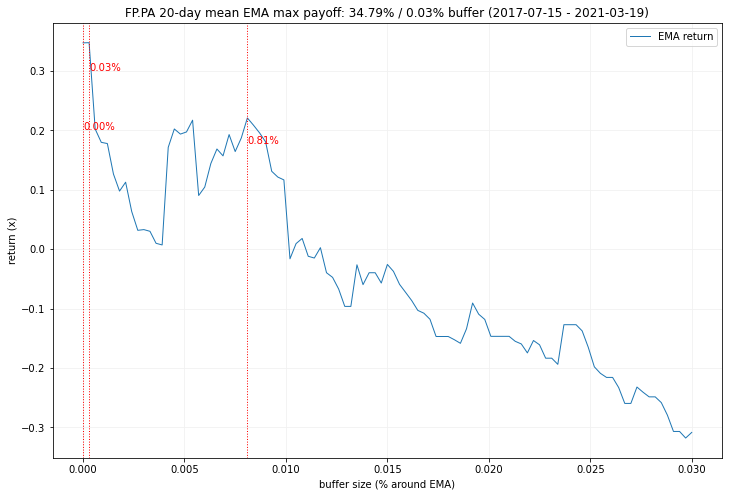

In [15]:
def plot_buffer_range(span, n_values=3, fee_pct=.04, extension='png'):
    buffer_range = [0, .03]
    buffers = np.linspace(buffer_range[0],
                          buffer_range[1],
                          101)
    emas = []
    for buffer in buffers:
        df = get_strategy(security.loc[start_date:end_date, :].copy(),
                          span,
                          buffer,)
        fee = get_fee(df, fee_pct)
        emas.append(get_cumret(df, 'ema',
                               fee)
                    )
    df = pd.DataFrame(data=[buffers, emas]).T
    df.columns = ['buffer', 'ema']
    max_val = df['ema'].max()
    min_val = df['ema'].min()
    val_range = max_val - min_val   

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df.buffer,
            df.ema,
            linewidth=1,
            label='EMA return',
            )
    ax.legend(loc='best')
    ax.set_xlabel('buffer size (% around EMA)')
    ax.set_ylabel('return (x)')

    largest_idx = pd.Series(df['ema'].nlargest(n_values)).index
    for large in largest_idx:
        ax.axvline(df.iloc[large][0],
                   color='r',
                   linestyle=':',
                   linewidth=1)
        text = f'{df.iloc[large][0]:.2%}'
        ax.annotate(text=text,
                    xy=(df.iloc[large][0],
                        min_val + np.random.uniform(0, 1)*val_range),
                    color='r'
                    )
    title = f'{TICKER} {span}-day mean EMA max payoff: {max_val:.2%} / ' 
    title += f'{df.iloc[largest_idx[0]][0]:.2%} buffer ' 
    title += f'({start_date} - {end_date})'
    ax.set_title(title)
        

    plt.grid(b=None, which='major', axis='both', color='#f1f1f1')

    plot_filename = f'{TICKER}_{start_date}-{end_date}_buffers'
    save_figure(plot_filename)

# test driver
plot_buffer_range(20)

### Interactive plots

#### Widget defaults

In [16]:
string_style = {'description_width': 'initial'}
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = .004

min_span     = 1
max_span     = 90
delta_span   = 1
default_span = 20

min_buffer = 0
max_buffer = .03
delta_buffer = .0001
default_buffer = .01

max_value = 12
default_value = 3

start_date = '2017-07-15'

#### Interactive buffer-span

In [17]:
fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         )

span_slider = IntSlider(min=min_span,
                        max=max_span,
                        step=delta_span,
                        value=default_span,
                        description='Window:',
                        style=string_style,
                        disabled=False,
                        continuous_update=False,
                        readout=True,
                        readout_format='d',
                        )

buffer_slider = FloatSlider(min=min_buffer,
                            max=max_buffer,
                            step=delta_buffer,
                            value=default_buffer,
                            style=string_style,
                            continuous_update=False,
                            description='Buffer (%):',
                            disabled=False,
                            readout=True,
                            readout_format='.2%',
                            )

ui = widgets.TwoByTwoLayout(top_left=fee_slider,
                            #top_right    = reactivity_slider,
                            bottom_left=span_slider,
                            bottom_right=buffer_slider,
                            )

out = widgets.interactive_output(plot_moving,
                                 {'span': span_slider,
                                  'buffer': buffer_slider,
                                  'fee_pct': fee_slider,
                                  # 'reactivity': reactivity_slider,
                                  }
                                 )

display(ui, out)

TwoByTwoLayout(children=(FloatSlider(value=0.004, continuous_update=False, description='Fees (%):', layout=Lay…

Output()

#### Interactive returns for window span

In [18]:
buffer_slider = FloatSlider(min=min_buffer,
                            max=max_buffer,
                            step=delta_buffer,
                            value=default_buffer,
                            style=string_style,
                            continuous_update=False,
                            description='Buffer (%):',
                            disabled=False,
                            readout=True,
                            readout_format='.2%',
                            )

max_values_slider = SelectionSlider(options=[x for x in range(0, max_value+1)],
                                    value=default_value,
                                    description='Number of maxima:',
                                    style=string_style,
                                    disabled=False,
                                    continuous_update=False,
                                    readout=True,
                                    readout_format='d',
                                    )

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         )

ui  = widgets.HBox([buffer_slider, fee_slider, max_values_slider])

out = widgets.interactive_output(plot_span_range,
                                 {'buffer': buffer_slider,
                                  'n_values': max_values_slider,
                                  'fee_pct': fee_slider,
                                  }
                                 )

display(ui, out)

Output()

#### Interactive returns for buffer size

In [19]:
span_slider = IntSlider(min=min_span,
                        max=max_span,
                        step=delta_span,
                        value=default_span,
                        description='Window:',
                        style=string_style,
                        disabled=False,
                        continuous_update=False,
                        readout=True,
                        readout_format='d',
                        )

max_values_slider = SelectionSlider(options=[x for x in range(0, max_value+1)],
                                    value=default_value,
                                    description='Number of maxima:',
                                    style=string_style,
                                    disabled=False,
                                    continuous_update=False,
                                    readout=True,
                                    readout_format='d',
                                    )

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         )

ui  = widgets.HBox([span_slider, fee_slider, max_values_slider])
out = widgets.interactive_output(plot_buffer_range,
                                 {'n_values': max_values_slider,
                                  'span': span_slider,
                                  'fee_pct': fee_slider,
                                  }
                                 )

display(ui, out)

Output()